In [1]:
import numpy as np
import h5py
import unet_uae as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
input_shape=(80,80,2)
depth = 10
vae_model,_ = vae_util.create_vae(input_shape, depth)
#vae_model.summary()

output shape is  (None, 10, 80, 80, 1)


In [3]:
def load_data(data_path, array_name_list):
    hf_r = h5py.File(data_path, 'r')
    result = []
    for name in array_name_list:
        result.append(np.array(hf_r.get(name)))
    hf_r.close()
    return result

In [4]:
data_dir = '/data3/Astro/cnn_surrogate_meng/topics/channel_80x80_l100_10step_2000days/data/'
# load training data
data_path = os.path.join(data_dir, 'channel_80x80_25w_lhs2967_bhp3_2000d_runs_3.h5')
p_t, logk = load_data(data_path, ['pressure', 'logk'])
# load eval data
print('p_t shape is ', p_t.shape)
print('logk shape is ', logk.shape)

p_t shape is  (2967, 41, 80, 80)
logk shape is  (2967, 1, 80, 80)


In [5]:
depth = 10
nr = logk.shape[0]
train_nr = 1500
test_nr = 50

In [6]:
p_t_mean = np.mean(p_t[:train_nr, ...], axis = 0, keepdims = True)
p_t = p_t - p_t_mean
print('max p is ', np.max(p_t[:train_nr, ...]), ', min p is ', np.min(p_t[:train_nr, ...]))
max_p = np.max(p_t[:train_nr, ...])
min_p = np.min(p_t[:train_nr, ...])

max p is  84.27208540634274 , min p is  -90.98400769142245


In [7]:
p_t = (p_t - min_p)/(max_p -min_p) - 0.5
print('max p is ', np.max(p_t), ', min p is ', np.min(p_t))
print('max p train is ', np.max(p_t[:train_nr, ...]), ', min p train is ', np.min(p_t[:train_nr, ...]))

max p is  0.5 , min p is  -0.5081386220006174
max p train is  0.5 , min p train is  -0.5


In [8]:
step_index = [1, 2, 4, 6, 8, 10, 12, 14, 17, 20]

train_x = np.concatenate([logk[:train_nr, ...],p_t[:train_nr,[0], ...]], axis = 1)
train_y = p_t[:train_nr,step_index,...]

test_x = np.concatenate([logk[nr-test_nr:, ...],  p_t[nr-test_nr:, [0], ...]], axis = 1)
test_y = p_t[nr-test_nr:,step_index,...]


train_x = train_x.transpose(0,2,3,1)
train_y = train_y[:,:,:,:,None]
test_x = test_x.transpose(0,2,3,1)
test_y = test_y[:,:,:,:,None]
#test_y = test_y.transpose(0,2,3,1)
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)


train_x shape is  (1500, 80, 80, 2)
train_y shape is  (1500, 10, 80, 80, 1)
test_x shape is  (50, 80, 80, 2)
test_y shape is  (50, 10, 80, 80, 1)


<Figure size 432x288 with 0 Axes>

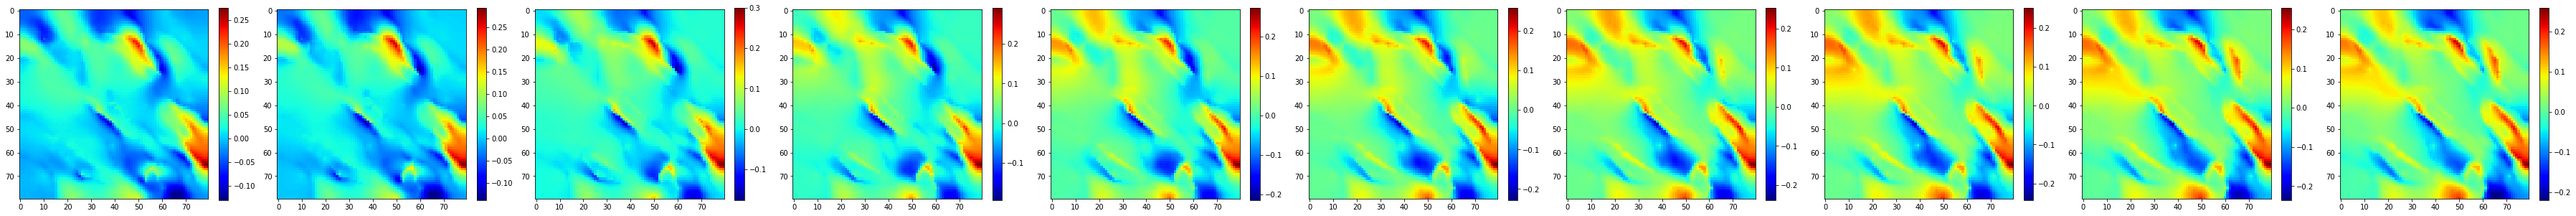

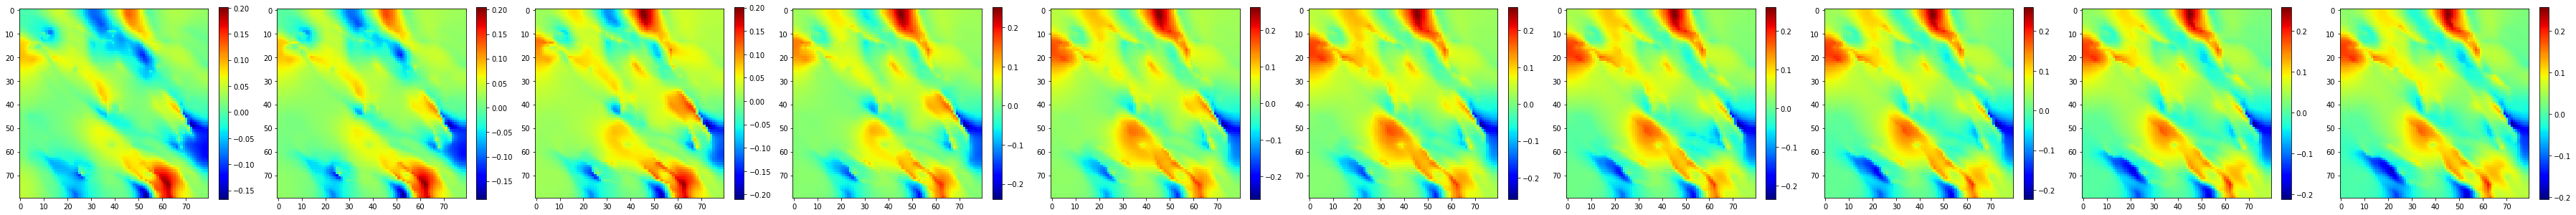

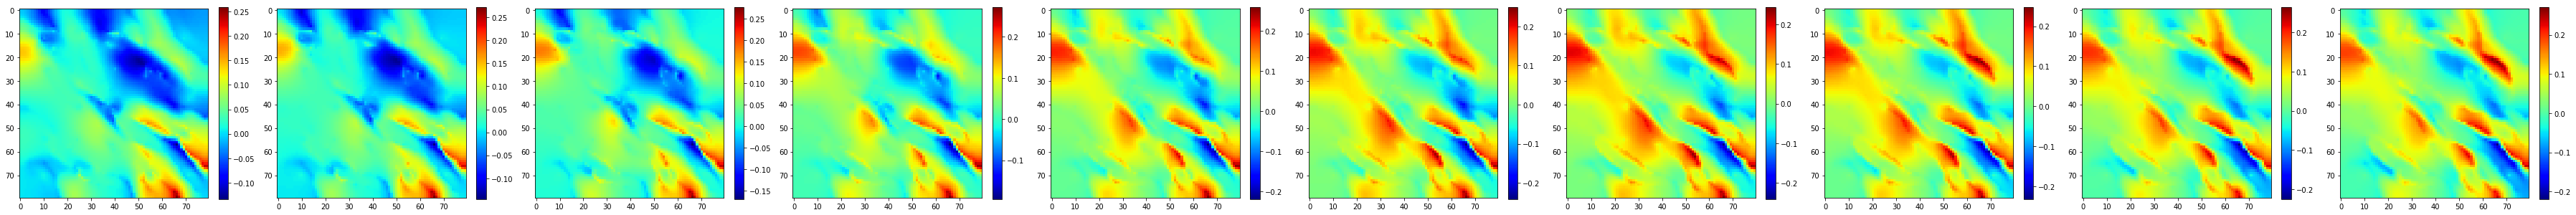

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')
ind_case = [0, 10, 20]

for k in range(len(ind_case)):
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(1, depth, i_tstep+1)
        plt.imshow(train_y[k, i_tstep, :, :, 0])
        plt.colorbar(fraction=0.046)
        plt.tight_layout()
plt.show()

In [10]:
output_dir = 'saved_models/'

In [11]:
epochs = 500
train_nr = train_x.shape[0]
test_nr = 10
batch_size = 16
num_batch = int(train_nr/batch_size) 

In [12]:
def vae_loss(x, t_decoded):
    '''Total loss for the plain UAE'''
    return K.mean(reconstruction_loss(x, t_decoded))



def reconstruction_loss(x, t_decoded): # abs loss
    '''Reconstruction loss for the plain UAE'''

    return K.sum(K.abs(K.batch_flatten(x) - K.batch_flatten(t_decoded)) , axis=-1)


def relative_error(x, t_decoded):
    return K.mean(K.abs(x - t_decoded) / x)

In [13]:
opt = Adam(lr=3e-4)
vae_model.compile(loss = vae_loss, optimizer = opt, metrics = [relative_error])

In [14]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lrScheduler = ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 10, cooldown = 1, verbose = 1, min_lr = 1e-6)
filePath = 'saved_models/saved-model-pressure-mae-{epoch:03d}-{val_loss:.2f}.h5'
checkPoint = ModelCheckpoint(filePath, monitor = 'val_loss', verbose = 1, save_best_only = False, \
                             save_weights_only = True, mode = 'auto', period = 20)

callbacks_list = [lrScheduler, checkPoint]

In [15]:
history = vae_model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, \
                        verbose = 1, validation_data = (test_x, test_y), callbacks = callbacks_list)

Train on 1500 samples, validate on 50 samples
Epoch 1/500
1500/1500 [==============================] - 31s 21ms/step - loss: 7840.3711 - relative_error: 6.8425 - val_loss: 4027.9373 - val_relative_error: 1.1774
Epoch 2/500
1500/1500 [==============================] - 22s 15ms/step - loss: 3496.5831 - relative_error: 4.6765 - val_loss: 22361.9212 - val_relative_error: -4.6178
Epoch 3/500
1500/1500 [==============================] - 22s 15ms/step - loss: 3500.0154 - relative_error: 2.3455 - val_loss: 3301.0648 - val_relative_error: 0.2564
Epoch 4/500
1500/1500 [==============================] - 22s 15ms/step - loss: 3241.3010 - relative_error: 0.7236 - val_loss: 5510.0786 - val_relative_error: -1.9607
Epoch 5/500
1500/1500 [==============================] - 22s 15ms/step - loss: 3288.5834 - relative_error: 1.5010 - val_loss: 3190.9545 - val_relative_error: -0.1113
Epoch 6/500
1500/1500 [==============================] - 22s 15ms/step - loss: 3155.8511 - relative_error: 1.0401 - val_loss:

1500/1500 [==============================] - 22s 15ms/step - loss: 600.5972 - relative_error: 2.0022 - val_loss: 724.3946 - val_relative_error: 0.0107
Epoch 50/500
1500/1500 [==============================] - 22s 15ms/step - loss: 590.0239 - relative_error: 1.3392 - val_loss: 650.5013 - val_relative_error: 0.0323
Epoch 51/500
1500/1500 [==============================] - 22s 15ms/step - loss: 580.3567 - relative_error: 1.2381 - val_loss: 666.8639 - val_relative_error: 0.1206
Epoch 52/500
1500/1500 [==============================] - 22s 14ms/step - loss: 557.4736 - relative_error: 1.1336 - val_loss: 705.1395 - val_relative_error: 0.1064
Epoch 53/500
1500/1500 [==============================] - 22s 15ms/step - loss: 561.4513 - relative_error: 1.0229 - val_loss: 675.2819 - val_relative_error: 0.0352
Epoch 54/500
1500/1500 [==============================] - 22s 15ms/step - loss: 547.4944 - relative_error: 1.4019 - val_loss: 643.4894 - val_relative_error: 0.0846
Epoch 55/500
1500/1500 [=====

1500/1500 [==============================] - 19s 13ms/step - loss: 376.9558 - relative_error: 0.2237 - val_loss: 483.3114 - val_relative_error: 0.0422
Epoch 99/500
1500/1500 [==============================] - 19s 13ms/step - loss: 363.5526 - relative_error: 0.5412 - val_loss: 520.0733 - val_relative_error: 0.1271
Epoch 100/500
1500/1500 [==============================] - 22s 15ms/step - loss: 370.3336 - relative_error: 0.5622 - val_loss: 473.2829 - val_relative_error: 0.1148

Epoch 00100: saving model to saved_models/saved-model-pressure-mae-100-473.28.h5
Epoch 101/500
1500/1500 [==============================] - 22s 15ms/step - loss: 362.5613 - relative_error: 1.0394 - val_loss: 489.0023 - val_relative_error: 0.1318
Epoch 102/500
1500/1500 [==============================] - 22s 15ms/step - loss: 361.9039 - relative_error: 0.9331 - val_loss: 487.4038 - val_relative_error: 0.1557
Epoch 103/500
1500/1500 [==============================] - 21s 14ms/step - loss: 365.0194 - relative_error: 

Epoch 146/500
1500/1500 [==============================] - 22s 15ms/step - loss: 270.1381 - relative_error: 0.4064 - val_loss: 402.6509 - val_relative_error: 0.1151
Epoch 147/500
1500/1500 [==============================] - 22s 15ms/step - loss: 277.1696 - relative_error: 0.6586 - val_loss: 428.6647 - val_relative_error: 0.1389
Epoch 148/500
1500/1500 [==============================] - 22s 14ms/step - loss: 277.0528 - relative_error: 0.5933 - val_loss: 407.9845 - val_relative_error: 0.0739
Epoch 149/500
1500/1500 [==============================] - 22s 14ms/step - loss: 277.2804 - relative_error: 0.6444 - val_loss: 417.6304 - val_relative_error: 0.1097
Epoch 150/500
1500/1500 [==============================] - 22s 15ms/step - loss: 273.7434 - relative_error: 0.2607 - val_loss: 395.3240 - val_relative_error: 0.0915
Epoch 151/500
1500/1500 [==============================] - 22s 15ms/step - loss: 270.4876 - relative_error: 0.7884 - val_loss: 400.5594 - val_relative_error: 0.0998
Epoch 152/

1500/1500 [==============================] - 22s 14ms/step - loss: 253.2751 - relative_error: 0.5276 - val_loss: 401.9329 - val_relative_error: 0.1271
Epoch 195/500
1500/1500 [==============================] - 22s 15ms/step - loss: 269.6384 - relative_error: 0.3800 - val_loss: 383.0156 - val_relative_error: 0.1234
Epoch 196/500
1500/1500 [==============================] - 22s 14ms/step - loss: 257.2891 - relative_error: 0.5013 - val_loss: 390.1908 - val_relative_error: 0.0980
Epoch 197/500
1500/1500 [==============================] - 22s 15ms/step - loss: 258.8313 - relative_error: 0.1766 - val_loss: 398.5925 - val_relative_error: 0.1282
Epoch 198/500
1500/1500 [==============================] - 22s 14ms/step - loss: 251.6524 - relative_error: 0.2655 - val_loss: 391.5399 - val_relative_error: 0.0947
Epoch 199/500
1500/1500 [==============================] - 22s 15ms/step - loss: 257.7099 - relative_error: 0.4081 - val_loss: 419.6153 - val_relative_error: 0.1413
Epoch 200/500
1500/1500 

1500/1500 [==============================] - 23s 15ms/step - loss: 215.0510 - relative_error: 0.5995 - val_loss: 368.4770 - val_relative_error: 0.1118
Epoch 242/500
1500/1500 [==============================] - 23s 15ms/step - loss: 216.2881 - relative_error: 0.4791 - val_loss: 371.2640 - val_relative_error: 0.1151
Epoch 243/500
1500/1500 [==============================] - 23s 15ms/step - loss: 209.9732 - relative_error: 0.4620 - val_loss: 369.8694 - val_relative_error: 0.1021
Epoch 244/500
1500/1500 [==============================] - 23s 15ms/step - loss: 216.1975 - relative_error: 0.3029 - val_loss: 373.1058 - val_relative_error: 0.1107
Epoch 245/500
1500/1500 [==============================] - 23s 15ms/step - loss: 219.9768 - relative_error: 0.4708 - val_loss: 369.2569 - val_relative_error: 0.0947
Epoch 246/500
1500/1500 [==============================] - 23s 15ms/step - loss: 213.9846 - relative_error: 0.5114 - val_loss: 372.2729 - val_relative_error: 0.1010
Epoch 247/500
1500/1500 

1500/1500 [==============================] - 23s 15ms/step - loss: 204.4642 - relative_error: 0.3606 - val_loss: 363.9910 - val_relative_error: 0.0967
Epoch 289/500
1500/1500 [==============================] - 23s 15ms/step - loss: 198.3356 - relative_error: 0.3775 - val_loss: 363.7045 - val_relative_error: 0.0983
Epoch 290/500
1500/1500 [==============================] - 23s 15ms/step - loss: 210.1168 - relative_error: 0.4691 - val_loss: 363.1300 - val_relative_error: 0.0937
Epoch 291/500
1500/1500 [==============================] - 23s 15ms/step - loss: 205.7910 - relative_error: 0.3363 - val_loss: 365.5407 - val_relative_error: 0.0966
Epoch 292/500
1500/1500 [==============================] - 23s 15ms/step - loss: 210.3161 - relative_error: 0.0783 - val_loss: 364.0076 - val_relative_error: 0.0967
Epoch 293/500
1500/1500 [==============================] - 23s 15ms/step - loss: 206.5435 - relative_error: 0.2432 - val_loss: 363.8232 - val_relative_error: 0.0932
Epoch 294/500
1500/1500 

1500/1500 [==============================] - 22s 15ms/step - loss: 201.7997 - relative_error: 0.7020 - val_loss: 362.2233 - val_relative_error: 0.0948
Epoch 336/500
1500/1500 [==============================] - 22s 15ms/step - loss: 207.8090 - relative_error: 0.3451 - val_loss: 362.5968 - val_relative_error: 0.0961
Epoch 337/500
1500/1500 [==============================] - 22s 15ms/step - loss: 196.3566 - relative_error: 0.4892 - val_loss: 362.5306 - val_relative_error: 0.0970
Epoch 338/500
1500/1500 [==============================] - 22s 14ms/step - loss: 206.4564 - relative_error: 0.3163 - val_loss: 362.9590 - val_relative_error: 0.0959
Epoch 339/500
1500/1500 [==============================] - 22s 15ms/step - loss: 203.7553 - relative_error: 0.3085 - val_loss: 362.6613 - val_relative_error: 0.0957
Epoch 340/500
1500/1500 [==============================] - 22s 15ms/step - loss: 206.5607 - relative_error: 0.3954 - val_loss: 362.2215 - val_relative_error: 0.0934

Epoch 00340: saving mod

1500/1500 [==============================] - 22s 15ms/step - loss: 206.2538 - relative_error: 0.3877 - val_loss: 362.3647 - val_relative_error: 0.0959
Epoch 384/500
1500/1500 [==============================] - 22s 15ms/step - loss: 210.8162 - relative_error: 0.4342 - val_loss: 362.2417 - val_relative_error: 0.0984
Epoch 385/500
1500/1500 [==============================] - 22s 15ms/step - loss: 200.8957 - relative_error: 0.5274 - val_loss: 362.2327 - val_relative_error: 0.0966
Epoch 386/500
1500/1500 [==============================] - 22s 15ms/step - loss: 202.9813 - relative_error: 0.2718 - val_loss: 362.1768 - val_relative_error: 0.0971
Epoch 387/500
1500/1500 [==============================] - 22s 15ms/step - loss: 202.0333 - relative_error: 0.5986 - val_loss: 362.1939 - val_relative_error: 0.0971
Epoch 388/500
1500/1500 [==============================] - 22s 15ms/step - loss: 207.0833 - relative_error: 0.4930 - val_loss: 362.3401 - val_relative_error: 0.0943
Epoch 389/500
1500/1500 

Epoch 432/500
1500/1500 [==============================] - 22s 14ms/step - loss: 204.1965 - relative_error: 0.4503 - val_loss: 362.4627 - val_relative_error: 0.0953
Epoch 433/500
1500/1500 [==============================] - 22s 14ms/step - loss: 200.8261 - relative_error: 0.5318 - val_loss: 362.1863 - val_relative_error: 0.0943
Epoch 434/500
1500/1500 [==============================] - 22s 14ms/step - loss: 208.9882 - relative_error: 0.4161 - val_loss: 361.9673 - val_relative_error: 0.0962
Epoch 435/500
1500/1500 [==============================] - 22s 14ms/step - loss: 205.8283 - relative_error: 0.2355 - val_loss: 362.3534 - val_relative_error: 0.0952
Epoch 436/500
1500/1500 [==============================] - 22s 14ms/step - loss: 205.3075 - relative_error: 0.5936 - val_loss: 362.3277 - val_relative_error: 0.0929
Epoch 437/500
1500/1500 [==============================] - 22s 14ms/step - loss: 198.8485 - relative_error: 0.6464 - val_loss: 362.4064 - val_relative_error: 0.0940
Epoch 438/

1500/1500 [==============================] - 22s 14ms/step - loss: 209.6363 - relative_error: 0.3556 - val_loss: 362.3725 - val_relative_error: 0.0958

Epoch 00480: saving model to saved_models/saved-model-pressure-mae-480-362.37.h5
Epoch 481/500
1500/1500 [==============================] - 22s 14ms/step - loss: 207.9902 - relative_error: 0.2428 - val_loss: 362.7359 - val_relative_error: 0.0928
Epoch 482/500
1500/1500 [==============================] - 22s 14ms/step - loss: 205.9552 - relative_error: 0.4654 - val_loss: 362.3984 - val_relative_error: 0.0950
Epoch 483/500
1500/1500 [==============================] - 22s 15ms/step - loss: 199.5726 - relative_error: 0.4320 - val_loss: 362.7886 - val_relative_error: 0.0929
Epoch 484/500
1500/1500 [==============================] - 22s 14ms/step - loss: 201.6862 - relative_error: 0.3626 - val_loss: 362.3056 - val_relative_error: 0.0961
Epoch 485/500
1500/1500 [==============================] - 22s 14ms/step - loss: 201.8892 - relative_error: